In [3]:
import glob
import os
from typing import Any, Dict, List, Tuple, Union

import torch
import yaml
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder, VisionDataset

from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from model import CustomVGG
import torchvision

In [ ]:
device = 'cuda'
lr = 0.0001
num_epoch = 60

input_size = 112 #224//2
batch_size = 128
n_worker = 8

In [ ]:
import torchvision.transforms.functional as TF
import random

class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

rotation_transform = MyRotationTransform(angles=[0, 180, 90, 270])

In [ ]:
normalize = transforms.Normalize(mean= [0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225])

train_dataset = ImageFolder(
    "/opt/ml/data/train", transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.RandomCrop(input_size),
        transforms.RandomHorizontalFlip(),
        MyRotationTransform(angles=[0, 180, 90, 270]),
        transforms.ToTensor(),
        normalize,
    ]))

val_dataset = ImageFolder("/opt/ml/data/val", transforms.Compose([
        transforms.Resize((input_size, input_size)),
        #transforms.Resize(int(input_size/0.875)),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        normalize,
    ]))

In [2]:
dir(train_dataset)

NameError: name 'train_dataset' is not defined

In [5]:
from torch.utils.data.sampler import WeightedRandomSampler

sample_freq = [1169, 4826, 1020, 2655, 4879, 1092] #[0] * len(train_dataset.classes) #df_ff.gender.value_counts().sort_index().to_numpy()
sample_weight = np.concatenate([[1/f]*f for f in sample_freq])
sample_weight = torch.from_numpy(sample_weight)
sampler = WeightedRandomSampler(sample_weight.type('torch.DoubleTensor'), len(sample_weight)//2)

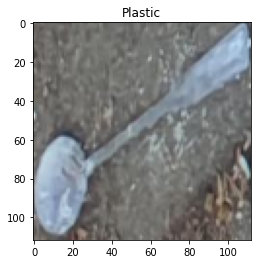

In [6]:
idx = np.random.randint(0, len(train_dataset))
img, label = train_dataset[idx]
img = img.permute(1,2,0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
plt.imshow(img)
plt.title(train_dataset.classes[label])
plt.show()

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, drop_last=True, sampler = sampler,
    num_workers=n_worker)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, shuffle=False,
    num_workers=n_worker)

dataloaders = { 'train' : train_loader, 'valid' : val_loader}

In [8]:
model = torchvision.models.resnet18(pretrained=False)
model.load_state_dict(torch.load('/opt/ml/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth'))
model.layer4 = torch.nn.Identity()
model.avgpool = torch.nn.Flatten()
model.fc = torch.nn.Sequential(torch.nn.Dropout(), torch.nn.Linear(256*7*7, 1024), torch.nn.ReLU(True), torch.nn.Dropout(), torch.nn.Linear(1024, 6))

# model.classifier = torch.nn.Sequential(
#             #torch.nn.Dropout(p=0.5, inplace=False),
#             torch.nn.Linear(512, 512),
#             torch.nn.ReLU(True),
#             torch.nn.Dropout(p=0.5, inplace=False),
#             #nn.Linear(int(4096*width_scale), int(4096*width_scale)),
#             #nn.ReLU(True),
#             #nn.Dropout(p=dropout),
#             torch.nn.Linear(512, 6),
#         )
# model.avgpool = torch.nn.AvgPool2d(7)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler =   optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', verbose=True, patience=5) # optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=0.000001)#

In [10]:
from trainer import Trainer

trainer = Trainer('/opt/ml/code/save', seed=42)

In [11]:
trainer.train(model, dataloaders, criterion, optimizer, lr_scheduler, num_epoch, 10, 'dummy')

Epoch 1/60
----------


100%|██████████| 61/61 [00:21<00:00,  2.81it/s]


train Epoch: 1 Loss: 1.2787 Acc: 0.5220 F1: 0.5157


100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


valid Epoch: 1 Loss: 1.0114 Acc: 0.6300 F1: 0.5866

Epoch 2/60
----------


100%|██████████| 61/61 [00:20<00:00,  3.01it/s]


train Epoch: 2 Loss: 0.8924 Acc: 0.6683 F1: 0.6665


100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


valid Epoch: 2 Loss: 0.8754 Acc: 0.6795 F1: 0.6346

Epoch 3/60
----------


  0%|          | 0/61 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [12]:
model = torchvision.models.squeezenet1_0()
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   